# Search Strategy Demo Using CFA

Confirmatory Factor Analysis (CFA) is another commonly used data analysis method in social science. It can be regarded as an special case of SEM. This notebook uses CFA to construct a demo with RL NAS.

In [2]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import autogluon as ag
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Config plt to show Chinese.
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

## Read Data

In [3]:
# Read excel data to Dataframe.
df = pd.read_excel('./data/online_education_learning_focus.xlsx')

# Remove incomplete response.
df.dropna(inplace=True)

# Show basic information on this dataset.
# This is a dataset provided by a course from PKU summer school 
# and it's not public, so please do not spread it.
# I choose this data because I ran detailed OLS and SEM on this dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2926
Data columns (total 27 columns):
18、(提前提供课程资料，方便学生课前预习)                     2927 non-null int64
18、(重视学生的课堂出勤考评)                           2927 non-null int64
18、(对学生作业及学业表现给予及时有效的反馈)                   2927 non-null int64
18、(课堂引入互动环节，注重学生参与（提问讨论）)                 2927 non-null int64
18、(让学生个体或小组选择主题，完成讨论、设计、研究展示)             2927 non-null int64
18、(课后为学生提供辅导答疑)                           2927 non-null int64
18、(课程成绩考核除考试外，纳入课堂参与、小论文、课堂研究展示等过程性评价)    2927 non-null int64
19、(课前课后预复习)                               2927 non-null int64
19、(课堂上提问或主动回答问题)                          2927 non-null int64
19、(积极参与小组合作学习或课程有关的问题)                    2927 non-null int64
19、(在线课程学习容易走神，注意力分散)                      2927 non-null int64
19、(在线学习中做与课程无关的事（如浏览无关网页、打瞌睡）)            2927 non-null int64
19、(逃课)                                    2927 non-null int64
19、(按时完成和提交作业)                             2927 non-null int64
19、(课后与同学讨论

## Adequacy Test

In [4]:
# Those tests are necessary test to confirm if this dataset is 
# suitable for CFA.
_, pValue = calculate_bartlett_sphericity(df)
_, KMOModel = calculate_kmo(df)
print('pValue is %f (< 0.01 means excellent)' % pValue)
print('KMOModel is %f (> 0.8 means excellent)' % KMOModel)

pValue is 0.000000 (< 0.01 means excellent)
KMOModel is 0.945398 (> 0.8 means excellent)


# Conventional Method

You don't have to understand the _Conventional Method_ section. All you need to know is that I'm constructing a baseline for our NAS demo.

## Decide How Many Factors to Use

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:342: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  error = sp.sum(residual)


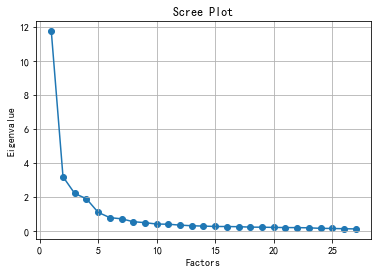

In [5]:
fa = FactorAnalyzer(25, rotation=None)
fa.fit(df)
ev, v = fa.get_eigenvalues()

# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:342: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  error = sp.sum(residual)


Total Variance Explained

[0.25284557 0.44925866 0.58802421 0.65731905]


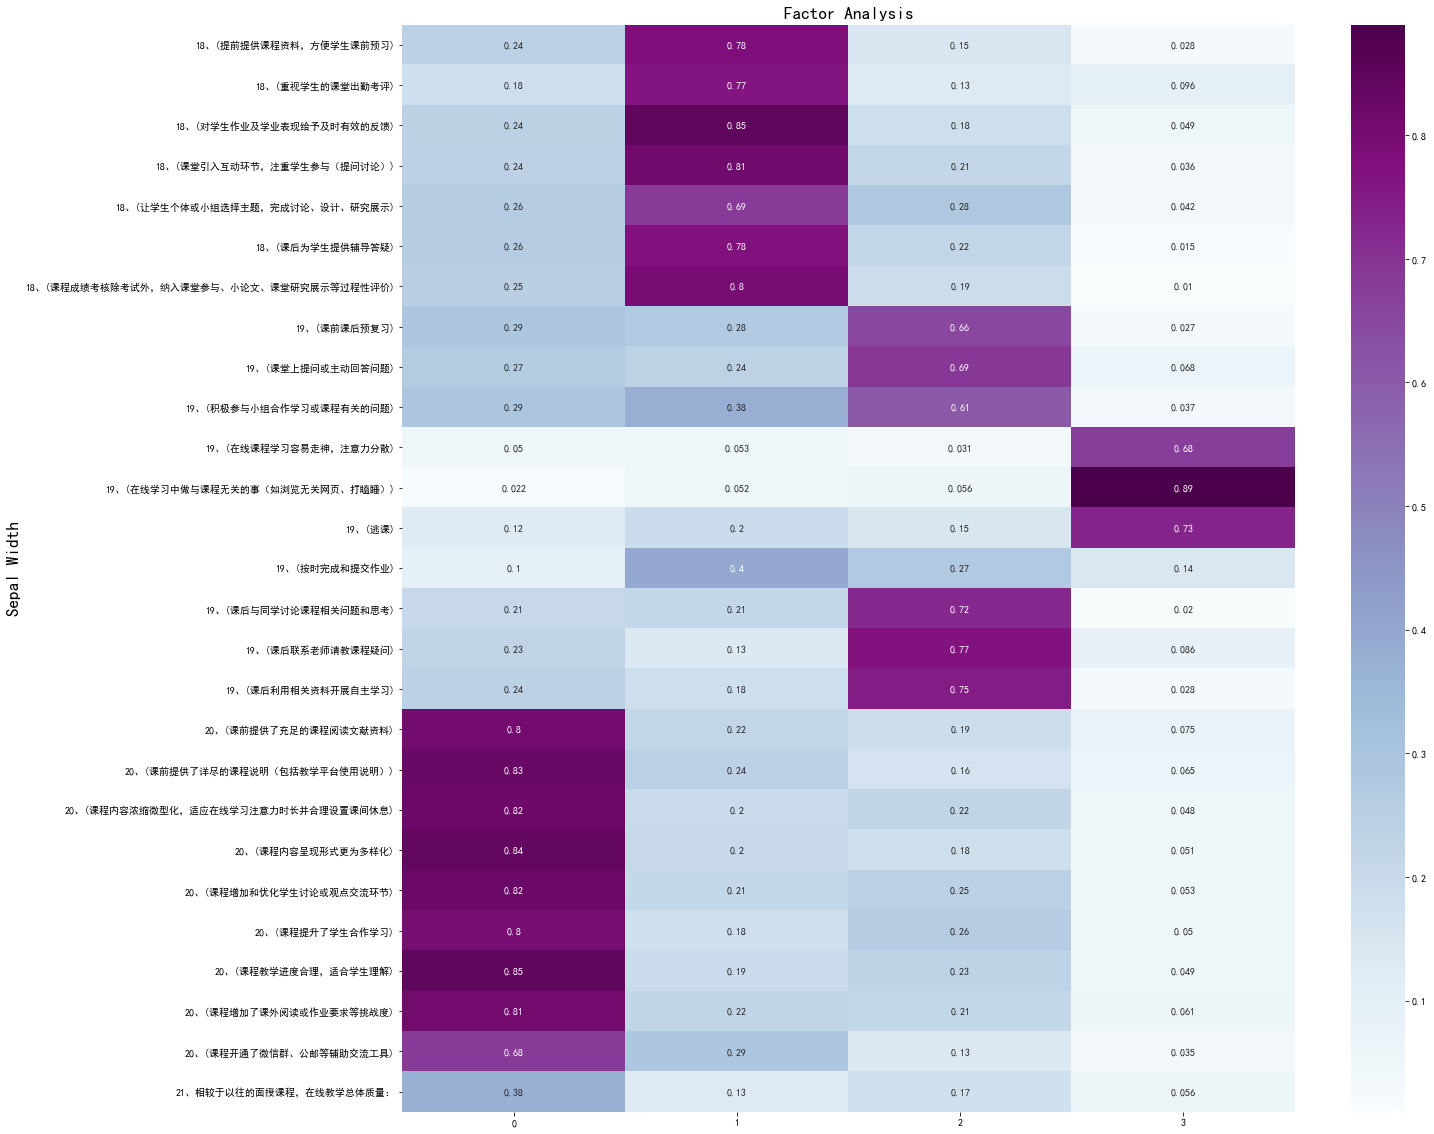

In [8]:
# Show how variables contribute to those 3 factors.
fa = FactorAnalyzer(4, rotation="varimax")
fa.fit(df)

# Plot the heatmap.
df_cm = pd.DataFrame(np.abs(fa.loadings_), index=df.columns)
plt.figure(figsize = (20,20))
ax = sns.heatmap(df_cm, annot=True, cmap="BuPu")
plt.title('Factor Analysis', fontsize='xx-large')
plt.ylabel('Sepal Width', fontsize='xx-large')

# The higher TVE is, the better.
print('Total Variance Explained\n')
print(fa.get_factor_variance()[2])

# NAS Approach

## Specify the Search Space

In [9]:
factorNum = 4
varNames = df.columns
varNum = len(varNames)

searchVar = dict(zip(
    [str(i) for i in range(varNum)], 
    [ag.space.Categorical(*list(range(factorNum))) for i in range(varNum)]))

covariance = np.cov(df, rowvar=False)

# Arg model_dict show be formatted as follow:
# model_dict = {'Factor1': ['Val1', 'Val2'], 'Factor2': ['Val3', 'Val4']}
def evaluateSolution(model_dict, verbose=False):
    model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df, model_dict)

    cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 
    cfa.fit(df.values)
    
    if (verbose):
        print('AIC: %f' % cfa.aic_)
        print('BIC: %f' % cfa.bic_)
        print('Log Likehood: %f' % cfa.log_likelihood_)
        print('Loadings: ', cfa.loadings_)
    
    AVE = np.sum(cfa.loadings_)
    varianceResedual = np.sum(np.abs(cfa.get_model_implied_cov() - covariance)) / 20
    
    return AVE - varianceResedual

@ag.args(**searchVar)
def rl_simulation(args, reporter):
    model_dict = dict(zip(
        [str(i) for i in range(factorNum)], 
        [[] for i in range(factorNum)]))
        
    for var, factor in args.items():
        if (var == 'task_id'): continue
        model_dict[str(factor)].append(varNames[int(var)])
    
    reward = evaluateSolution(model_dict)
    
    reporter(reward=reward)

## Use Random Search as Another Baseline

In [17]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=100,
                                              reward_attr='reward')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    random_scheduler.run()
    random_scheduler.join_jobs()
    
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))

scheduler_options: Key 'searcher': Imputing default value random
scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'time_attr': Imputing default value epoch
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 100



Best config: {'0▁choice': 3, '10▁choice': 3, '11▁choice': 0, '12▁choice': 0, '13▁choice': 0, '14▁choice': 0, '15▁choice': 2, '16▁choice': 3, '17▁choice': 3, '18▁choice': 3, '19▁choice': 2, '1▁choice': 3, '20▁choice': 3, '21▁choice': 3, '22▁choice': 3, '23▁choice': 0, '24▁choice': 3, '25▁choice': 3, '26▁choice': 1, '2▁choice': 3, '3▁choice': 0, '4▁choice': 1, '5▁choice': 0, '6▁choice': 1, '7▁choice': 0, '8▁choice': 3, '9▁choice': 3}, best reward: 20.878153693505595


## RL NAS

In [18]:
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=100,
                                        reward_attr='reward',
                                        controller_batch_size=4,
                                        controller_lr=5e-3,)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rl_scheduler.run()
    rl_scheduler.join_jobs()
    
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))

scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'checkpoint': Imputing default value ./exp/checkpoint.ag
scheduler_options: Key 'ema_baseline_decay': Imputing default value 0.95
scheduler_options: Key 'controller_resource': Imputing default value {'num_cpus': 0, 'num_gpus': 0}
scheduler_options: Key 'sync': Imputing default value True

scheduler_options: Key 'time_attr': Imputing default value epoch
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Reserved DistributedResource(
	Node = Remote REMOTE_ID: 0, 
	<Remote: 'inproc://192.168.2.94/84782/1' processes=1 threads=12, memory=17.18 GB>
	nCPUs = 0) in Remote REMOTE_ID: 0, 
	<Remote: 'inproc://192.168.2.94/84782/1' processes=1 threads=12, memory=17.18 GB>
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is


Best config: {'0▁choice': 0, '1▁choice': 3, '2▁choice': 1, '3▁choice': 0, '4▁choice': 3, '5▁choice': 3, '6▁choice': 2, '7▁choice': 2, '8▁choice': 1, '9▁choice': 0, '10▁choice': 0, '11▁choice': 3, '12▁choice': 2, '13▁choice': 0, '14▁choice': 3, '15▁choice': 2, '16▁choice': 3, '17▁choice': 1, '18▁choice': 3, '19▁choice': 3, '20▁choice': 1, '21▁choice': 3, '22▁choice': 1, '23▁choice': 3, '24▁choice': 0, '25▁choice': 2, '26▁choice': 1}, best reward: 21.935525695980825


## Plot the Learning Curve

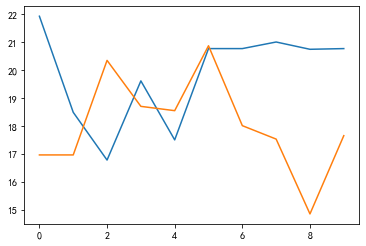

In [19]:
results_rl = [v[0]['reward'] for v in rl_scheduler.training_history.values()]
results_random = [v[0]['reward'] for v in random_scheduler.training_history.values()]

results1 = [np.max(results_random[i:i+10]) for i in range(0, len(results_random), 10)]
results2 = [np.max(results_rl[i:i+10]) for i in range(0, len(results_rl), 10)]

plt.plot(range(len(results2)), results2, range(len(results1)), results1)

# Compare Those Results

## Evaluate the Solution from Conventional CFA

In [20]:
convSolution = {str(i): [] for i in range(factorNum)}

for val, fac in enumerate(np.argmax(np.abs(fa.loadings_), axis=1)):
    convSolution[str(fac)].append(varNames[val])

print('Index: %f' % evaluateSolution(convSolution))

Index: 11.891884


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


## Evaluate the Solution from Random Search

In [21]:
randSolution = {str(i): [] for i in range(factorNum)}

randSolutionFA = random_scheduler.get_best_config()
for val, fac in randSolutionFA.items():
    randSolution[str(fac)].append(varNames[int(val.split('▁')[0])])
    
print('Index: %f' % evaluateSolution(randSolution))

Index: 20.878154


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


## Evaluate the Solution from RL Search

In [22]:
reinSolution = {str(i): [] for i in range(factorNum)}

reinSolutionFA = rl_scheduler.get_best_config()
for val, fac in reinSolutionFA.items():
    reinSolution[str(fac)].append(varNames[int(val.split('▁')[0])])

print('Index: %f' % evaluateSolution(reinSolution))

Index: 21.935526


## Show the Result from RL NAS

In [23]:
for i in reinSolution.keys():
    print('The %sst factor include the following variables' % i)
    for val in reinSolution[i]:
        print(val)

The 0st factor include the following variables
18、(提前提供课程资料，方便学生课前预习)
18、(课堂引入互动环节，注重学生参与（提问讨论）)
19、(积极参与小组合作学习或课程有关的问题)
19、(在线课程学习容易走神，注意力分散)
19、(按时完成和提交作业)
20、(课程增加了课外阅读或作业要求等挑战度)
The 1st factor include the following variables
18、(对学生作业及学业表现给予及时有效的反馈)
19、(课堂上提问或主动回答问题)
20、(课前提供了充足的课程阅读文献资料)
20、(课程内容呈现形式更为多样化)
20、(课程提升了学生合作学习)
21、相较于以往的面授课程，在线教学总体质量：
The 2st factor include the following variables
18、(课程成绩考核除考试外，纳入课堂参与、小论文、课堂研究展示等过程性评价)
19、(课前课后预复习)
19、(逃课)
19、(课后联系老师请教课程疑问)
20、(课程开通了微信群、公邮等辅助交流工具)
The 3st factor include the following variables
18、(重视学生的课堂出勤考评)
18、(让学生个体或小组选择主题，完成讨论、设计、研究展示)
18、(课后为学生提供辅导答疑)
19、(在线学习中做与课程无关的事（如浏览无关网页、打瞌睡）)
19、(课后与同学讨论课程相关问题和思考)
19、(课后利用相关资料开展自主学习)
20、(课前提供了详尽的课程说明（包括教学平台使用说明）)
20、(课程内容浓缩微型化，适应在线学习注意力时长并合理设置课间休息)
20、(课程增加和优化学生讨论或观点交流环节)
20、(课程教学进度合理，适合学生理解)
